In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import csv
import os
cwd = os.getcwd()
%matplotlib inline
pylab.rcParams['figure.figsize'] = (12, 8)


def settings_load(file_path):
    zeroth_row = True
    with open(file_path , 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter='=')
        output = dict()
        for row in reader:
            output[row[0]] = row[1]
    return output


def csv_load(file_path):
    zeroth_row = True
    with open(file_path , 'rb') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if zeroth_row == True:
                row.remove('')
                row = [float(value) for value in row]
                data = np.array(row)
                zeroth_row = False
            else:
                row.remove('')
                new_row = [float(value) for value in row]
                data = np.vstack([data, new_row])
    return data


def mean_photons_calc(probabilities):
    photons = np.zeros(probabilities.shape[1])
    for i in range(photons.shape[0]):
        for j in range(probabilities.shape[0]):
            photons[i] = photons[i] + j * probabilities[j, i]
    return photons


def times_qload(folder_path):
    times_path = folder_path + '/times'
    times = qload(times_path)
    times = times / (2 * np.pi * 1000)
    return times


def above(x, y, trials):
    difference = y[:, :, np.newaxis] - divider(x, trials)
    above_yn = difference > 0
    return above_yn


class Parameters:
    def __init__(self, wc, wq, eps, g, chi, kappa, gamma, t_levels, c_levels):
        self.wc = wc
        self.wq = wq
        self.eps = eps
        self.g = g
        self.chi = chi
        self.gamma = gamma
        self.kappa = kappa
        self.t_levels = t_levels
        self.c_levels = c_levels

    def copy(self):
        params = Parameters(self.wc, self.wq, self.eps, self.g, self.chi, self.kappa, self.gamma, self.t_levels, self.c_levels)
        return params


class Results:
    def __init__(self, params=np.array([]), wd_points=np.array([]),
                 transmissions=np.array([]), edge_occupations_c=np.array([]), edge_occupations_t=np.array([])):
        self.params = params
        self.wd_points = wd_points
        self.transmissions = transmissions
        self.edge_occupations_c = edge_occupations_c
        self.edge_occupations_t = edge_occupations_t
        self.abs_transmissions = np.absolute(self.transmissions)
        self.size = self.wd_points.size

    def concatenate(self, results):
        combined_params = np.concatenate([self.params, results.params])
        combined_wd_points = np.concatenate([self.wd_points, results.wd_points])
        combined_transmissions = np.concatenate([self.transmissions, results.transmissions])
        combined_edge_occupations_c = np.concatenate([self.edge_occupations_c, results.edge_occupations_c])
        combined_edge_occupations_t = np.concatenate([self.edge_occupations_t, results.edge_occupations_t])
        sort_indices = np.argsort(combined_wd_points)
        combined_params = combined_params[sort_indices]
        combined_wd_points = combined_wd_points[sort_indices]
        combined_transmissions = combined_transmissions[sort_indices]
        combined_edge_occupations_c = combined_edge_occupations_c[sort_indices]
        combined_edge_occupations_t = combined_edge_occupations_t[sort_indices]
        combined_results = Results(combined_params, combined_wd_points,
                                   combined_transmissions, combined_edge_occupations_c, combined_edge_occupations_t)
        return combined_results

    def delete(self, indices):
        reduced_params = np.delete(self.params, indices)
        reduced_wd_points = np.delete(self.wd_points, indices)
        reduced_transmissions = np.delete(self.transmissions, indices)
        reduced_edge_occupations_c = np.delete(self.edge_occupations_c, indices)
        reduced_edge_occupations_t = np.delete(self.edge_occupations_t, indices)
        reduced_results = Results(reduced_params, reduced_wd_points,
                                  reduced_transmissions, reduced_edge_occupations_c, reduced_edge_occupations_t)
        params_change = (reduced_params == self.params)
        wd_points_change = (reduced_wd_points == self.wd_points)
        transmissions_change = (reduced_transmissions == self.transmissions)
        edge_occupations_c_change = (reduced_edge_occupations_c == self.edge_occupations_c)
        edge_occupations_t_change = (reduced_edge_occupations_t == self.edge_occupations_t)
        print np.all([params_change, wd_points_change, transmissions_change, edge_occupations_c_change, edge_occupations_t_change])
        return reduced_results

    def queue(self):
        queue = Queue(self.params, self.wd_points)
        return queue


def fidelity_calc(set1, set2, trials):
    
    set1_above = np.sum(above(set1[0, :, :], set1[1, :, :], trials), axis=0)
    set1_total = set1.shape[1]
    set1_above_fraction = 1.0 * set1_above / set1_total
  
    set2_above = np.sum(above(set2[0, :, :], set2[1, :, :], trials), axis=0)
    set2_total = set2.shape[1]
    set2_above_fraction = 1.0 * set2_above / set2_total
       
    fidelity = 0.5 * (1 + np.abs(set1_above_fraction - set2_above_fraction))
    
    return fidelity


def initial_parameters_calc(set1, set2):
    set1_mean = np.mean(set1, axis=1)
    set2_mean = np.mean(set2, axis=1)
    midpoint = np.mean(np.array([set1_mean, set2_mean]), axis = 0)
    difference = set2_mean - set1_mean
    grad = difference[1] / difference[0]
    theta = np.arctan(-1 / grad)    
    return np.array([theta, midpoint[0], midpoint[1]]), difference


def divider(x, trials):
    y = (x[:, :, np.newaxis] - trials[1, np.newaxis, :, :]) * np.tan(trials[0, np.newaxis, :, :]) + trials[2, np.newaxis, :, :]
    return y
#traj, trial
#now traj, trial, timeslice
#trials feed in as parameter, timeslice, trial
#out traj, timeslice, trial
#x in traj, timeslice


def best_guess(set1, set2, trials):
    fidelities = fidelity_calc(set1, set2, trials)
    max_idx = np.argmax(fidelities, axis=1)
    best = np.zeros([3, max_idx.shape[0]])
    for i, j in enumerate(max_idx):
        best[:, i] = trials[:, i, j]
    return best

    
def new_trials(initial_trial, param_idx, region, points):
    trials = np.zeros([3, region.shape[0], points])
    for idx, reg in enumerate(region):
        trials[param_idx, idx, :] = np.linspace(-reg/2, reg/2, points)
    trials = trials + initial_trial[:, :, np.newaxis]
    return trials


def optimize(set1, set2):

    initial_trials, differences = initial_parameters_calc(set1, set2)
    theta_range = np.pi * np.ones([set1.shape[2]])
    x_range = np.linalg.norm(differences, axis=0)
    y_range = np.linalg.norm(differences, axis=0)
    n_trials = 9
    n_iterations = 5
    refinement = 1.5
    best_trials = initial_trials
    
    for idx in range(n_iterations):
        trials = new_trials(best_trials, 0, theta_range, n_trials)
        best_trials = best_guess(set1, set2, trials)
        trials = new_trials(best_trials, 1, x_range, n_trials)
        best_trials = best_guess(set1, set2, trials)
        trials = new_trials(best_trials, 2, y_range, n_trials)
        best_trials = best_guess(set1, set2, trials)
        theta_range = theta_range / refinement
        x_range = x_range / refinement
        y_range = y_range / refinement
    
    best_fidelities = fidelity_calc(set1, set2, best_trials[:, :, np.newaxis])
    
    return best_fidelities, best_trials

In [288]:
file_path = './qutip_spec/spectroscopy'
spectra = qload(file_path)

epsilon_q = []
frequencies_q = []
amplitudes_q = []

for key in spectra:
    spectrum = spectra[key]
    epsilon_q.append(key)
    max_index = np.argmax(spectrum.abs_transmissions)
    frequencies_q.append(spectrum.wd_points[max_index])
    amplitudes_q.append(spectrum.abs_transmissions[max_index])

epsilon_q = np.array(epsilon_q)
frequencies_q = np.array(frequencies_q)
amplitudes_q = np.array(amplitudes_q)
indices = np.argsort(epsilon_q)
epsilon_q = epsilon_q[indices]
frequencies_q = frequencies_q[indices]
amplitudes_q = amplitudes_q[indices]   

Loaded dict object.


In [235]:
conversion_constant = 15.34

def data_load(file_path):
    n_row = 0
    with open(file_path , 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        for row in reader:
            if n_row == 0:
                powers = np.array([float(value) for value in row])
            elif n_row == 1:
                frequencies = np.array([float(value) for value in row])
                data = np.zeros([len(powers), len(frequencies)])
            else:
                data[n_row - 2, :] = [float(value) for value in row]
            n_row += 1
    return powers, frequencies, data

def decibels(epsilon):
    d = 20 * np.log10(epsilon) + conversion_constant
    return d

def eps(dec):
    e = np.power(10, (dec - conversion_constant)/20)
    return e

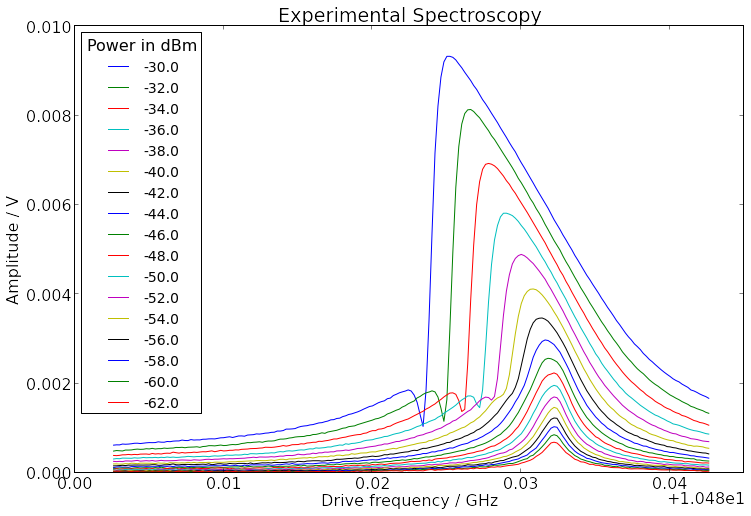

In [280]:
powers, frequencies, data = data_load('./third_cool_down/CavC_RfSweep_pRF.txt')
frequencies = frequencies / 1000000000
frequencies = frequencies + 0.0626

indices = np.argsort(powers)[::-1]
powers = powers[indices]
data = data[indices,:]

max_indices = np.argmax(data, axis=1)
frequencies_g = frequencies[max_indices]
amplitudes_g = np.array([data[i, max_indices[i]] for i  in range(data.shape[0])])

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.plot(frequencies, np.transpose(data))
plt.legend(powers, fontsize=14, loc=2, title='Power in dBm')
plt.xlabel('Drive frequency / GHz')
plt.ylabel('Amplitude / V')
plt.title('Experimental Spectroscopy')

Here I've plotted the experimental spectroscopy data Giovanna has provided for her device.

The parameters of the system are as follows:  
$\kappa = 1.47$ MHz  
$\gamma = 0.833$ MHz  
$g = 275$ MHz  
$f_c = 10.4267$ GHz  
$f_{01} = 9.39128$ GHz  
$f_r = 10.5122$ GHz  
$\delta = f_q - f_c = -1.03542$ GHz  
$\chi = -97$ MHz 

Increasing the drive power causes the resonance peak to shift to lower frequencies. We also start to see a dip below the resonance peak where destructive inteference between two bistable states reduces the amplitude of the oscillation of the resonator.
  
  My simulations are carried out using the following Hamiltonian:  
  $H = h (f_c - f_d) a^\dagger a + h (f_{01} - f_d) \sigma^+ \sigma^- + h g (a^\dagger \sigma^- + a \sigma^+) + h \epsilon (a + a^\dagger) $ 
  
 The drive applied to the cavity has a frequency of $f_d$ and an amplitude of $\epsilon$. We can simulate spectroscopy of the cavity by finding the steady state of the master equation:  
 $\frac{d \rho}{d t} = \frac{1}{ i h} [H, \rho] + \kappa \mathcal{D}[a] \rho + \gamma \mathcal{D}[\sigma^-]\rho$  
 The transmission through the cavity should be proportional to $\langle a \rangle$.  
 
 To link Giovanna's data to the results of a simulation we need some way of finding what $\epsilon$ corresponds to a particular drive power. Drive power should be proportional to drive amplitude squared so we expect something of the form:  
 $P = A \epsilon^2$  
 or  
 $D = 20 \log_{10}(\epsilon) + C$  
 where P is the drive power, D is the drive power in decibels and $C = 10 \log_{10}(A)$. Note that I will be measuring $\epsilon$ in GHz.
  
 Also note that the experimentally measured coupling of $g=275$ MHz is different to the value used in the model. Need to read the original transmon paper to understand why this is necessary. Themis knows. Something about the value of $g$ in the model being perturbed so that the measured $g$ is actually a different value. The value I use in my simulations is $g=309.6$ MHz and this is found by adjusting $g$ until the low power resonance peak occurs at the same frequency as in the experimental data.

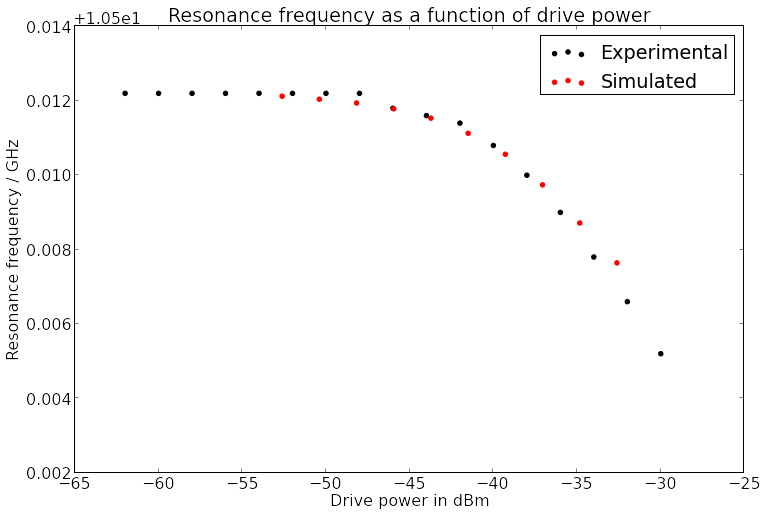

In [290]:
C = 15.34
powers_q = 20 * np.log10(epsilon_q) + C
plt.scatter(powers, frequencies_g, color='k')
plt.scatter(powers_q, frequencies_q, color='r')
plt.xlabel('Drive power in dBm')
plt.ylabel('Resonance frequency / GHz')
plt.legend(['Experimental', 'Simulated'])
plt.title('Resonance frequency as a function of drive power')

After tuning $g$ such that the low power resonance peak was at the correct frequency my next task was to find the conversion constant $C$ to move between drive amplitude $\epsilon$ and drive power in dBm. To do this I used qutip to simulate spectroscopy of the cavity over a range of drive frequencies. I then plotted experimental simulated resonance frequencies on the same graph as a function of drive power. L then adjusted $C$ until the experimental and simulated data lined up as best as possible. This gave $C = 15.34$.

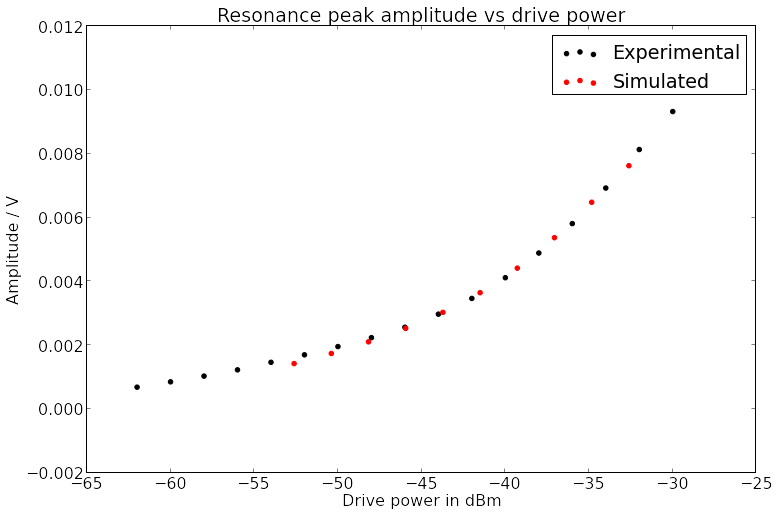

In [295]:
B = 0.0031
voltage_q = B * amplitudes_q
plt.scatter(powers, amplitudes_g, color='k')
plt.scatter(powers_q, voltage_q, color='r')
plt.xlabel('Drive power in dBm')
plt.ylabel('Amplitude / V')
plt.title('Resonance peak amplitude vs drive power')
plt.legend(['Experimental', 'Simulated'])

Next I had to find the conversion factor to go from $\langle a \rangle$ to the experimentally measured transmission, $T$, which is measured in volts. This conversion takes the form:  
$T = B \langle a \rangle$
Plotting experimental and simulated peak heights on the same graph and adjusting $B$ for the best fit gave $B=0.0031$.

Loaded dict object.


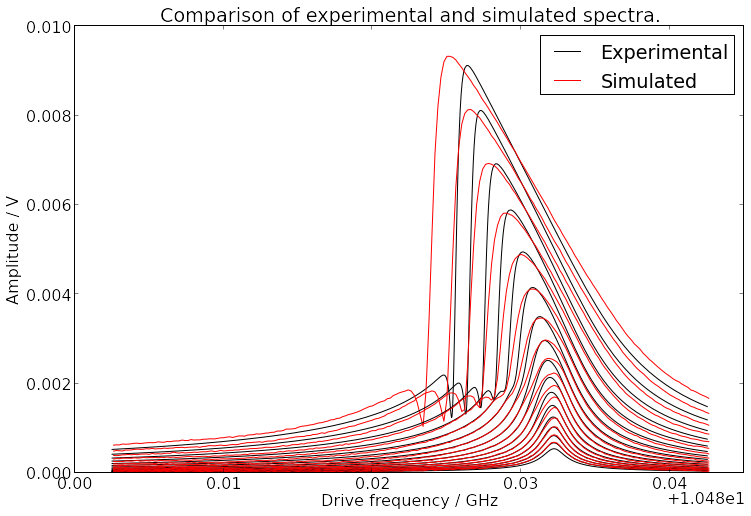

In [317]:
spectra = qload('./spec_reproduce/spectroscopy')
for idx, key in enumerate(sorted(spectra)[::-1]):
    plt.plot(spectra[key].wd_points, 0.0031 * spectra[key].abs_transmissions, color='k')
    plt.plot(frequencies, data[idx, :], color='r')
plt.xlabel('Drive frequency / GHz')
plt.ylabel('Amplitude / V')
plt.legend(['Experimental', 'Simulated'])
plt.title('Comparison of experimental and simulated spectra.')

Using the conversion constants $B$ and $C$ I then plotted experimental and simulated spectra on the same graph. Agreement isn't particularly good but I would say it is qualitatively accurate. The simulated spectra show the resonance peak shifting to lower frequencies as drive power is increased and it shows the formation of a dip.